## Part Four Manual Homography + Sticthing
1. Load im01.jpg and im02.jpg. Let the user to choose 4 points on im01.jpg and 4 points on im02.jpg


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
 
img1 = cv2.imread("im01.jpg")
img2 = cv2.imread("im02.jpg")
points1 = []
points2 = []
def first_on_EVENT_LBUTTONDOWN(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # the left mouse button is pressed
        # xy = "(%d,%d)" % (x, y)
        text = (x,y)
        points1.append((int(x), int(y)))
        cv2.circle(img1, text, 10, (255, 0, 0), thickness=4)
        # cv2.putText(img1, xy, (x+15, y+15), cv2.FONT_HERSHEY_PLAIN, 5, (255, 0, 0), thickness=5)
        cv2.imshow("image1", img1)


def second_on_EVENT_LBUTTONDOWN(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:  # the left mouse button is pressed
        # xy = "(%d,%d)" % (x, y)
        text = (x,y)
        points2.append((int(x), int(y)))
        cv2.circle(img2, (x, y), 6, (0, 0, 255), thickness=4)
        # cv2.putText(img2, xy, (x+10, y+10), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 255), thickness=3)
        cv2.imshow("image2", img2)

cv2.namedWindow("image1",cv2.WINDOW_KEEPRATIO)
cv2.setMouseCallback("image1", first_on_EVENT_LBUTTONDOWN)
cv2.imshow("image1", img1)

cv2.namedWindow("image2",cv2.WINDOW_KEEPRATIO)
cv2.setMouseCallback("image2", second_on_EVENT_LBUTTONDOWN)
cv2.imshow("image2", img2)
 
cv2.waitKey(0)

-1

2. Compute the homograhy matrix, and stitch the images together using the computed homography matrix and show the result.

In [106]:
def Homography(A):
    "do svd to matrix A and get the homography matrix"
    A = A/1.0
    _, _, V = np.linalg.svd(A)
    H1 = V[-1].reshape(3,3)
    H1  = H1/H1[2,2]
    return H1


def get_min_max(x,y,m):
    "get the minimum and maximum values of x and y"
    xmin,xmax,ymin,ymax = m
    if x < xmin:
        xmin = x
    elif x > xmax:
        xmax = x
    if y < ymin:
        ymin = y
    elif y > xmax:
        ymax = y
    return xmin,xmax,ymin,ymax


def trans(H, i1, i2):
    "transform the colored picture i1 to plane of i2"
    s1 = i1.shape
    s2 = i2.shape
    # shape = list(map(lambda x: x[0]+x[1]+400, zip(s1,s2)))
    # shape[-1] = 3
    shape = (1000,1500,3)
    # print(shape)
    result = np.zeros(shape, dtype=i1.dtype)    # create the black canvas
    print(type(result[0,0]))
    row, col = np.shape(i1)[:2]
    xmin,xmax,ymin,ymax = 0,0,0,0
    temp1 = list()
    temp2 = list()
    i = 0
    while i < row:
        j = 0
        while j < col:
            t = np.matrix([j,i,1]).reshape(3,1)
            res = H.dot(t)
            res /= res[2,0]
            x = round(res[0,0])
            y = round(res[1,0])
            xmin,xmax,ymin,ymax = get_min_max(x,y,[xmin,xmax,ymin,ymax])
            # print(i,j)
            temp1.append([y,x,i1[int(i),int(j),:]])
            # temp2.append([int(i),int(j),i2[int(i),int(j),:]])
            j += 0.3
        i += 0.3
    # print(xmin,xmax,ymin,ymax)

    for t in temp1:
        if ymin < 0:
            y = t[0]-ymin
        elif ymax > shape[0]:
            y = t[0]-ymax
        if xmin < 0:
            x = t[1]-xmin
        elif xmax > shape[1]:
            x = t[1]-xmax
        result[y,x] = t[2]

    i = 0
    while i < row:
        j = 0
        while j < col:
            if result[i-ymin,j-xmin].tolist() != result[0,0].tolist():
                result[i-ymin,j-xmin] = list(map(lambda x: (x[0]+x[1]), zip(i2[i,j,:]/2, result[i-ymin,j-xmin]/2)))
            else:
                result[i-ymin,j-xmin] = i2[i,j,:]
            j += 1
        i += 1

    final = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    return final 

def generate_A(points1, points2):
    x1, y1 = points1[0]
    x2, y2 = points1[1]
    x3, y3 = points1[2]
    x4, y4 = points1[3]
    x1_, y1_ = points2[0]
    x2_, y2_ = points2[1]
    x3_, y3_ = points2[2]
    x4_, y4_ = points2[3]
    
    A = np.matrix([[x1, y1, 1, 0, 0, 0, -x1*x1_, -y1*x1_, -x1_],
                [0, 0, 0, x1, y1, 1, -x1*y1_, -y1*y1_, -y1_],
                
                [x2, y2, 1, 0, 0, 0, -x2*x2_, -y2*x2_, -x2_],
                [0, 0, 0, x2, y2, 1, -x2*y2_, -y2*y2_, -y2_],
                
                [x3, y3, 1, 0, 0, 0, -x3*x3_, -y3*x3_, -x3_],
                [0, 0, 0, x3, y3, 1, -x3*y3_, -y3*y3_, -y3_],
                
                [x4, y4, 1, 0, 0, 0, -x4*x4_, -y4*x4_, -x4_],
                [0, 0, 0, x4, y4, 1, -x4*y4_, -y4*y4_, -y4_]])
    return A

<class 'numpy.ndarray'>


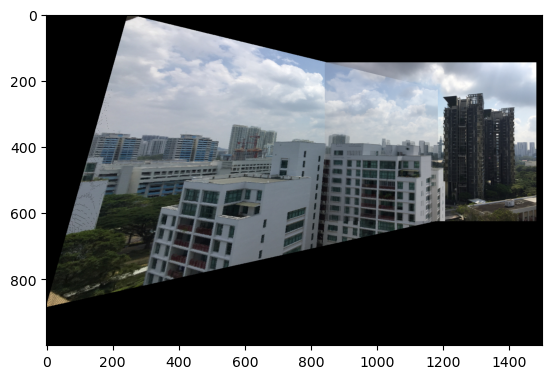

In [107]:
img1 = cv2.imread("im01.jpg")
img2 = cv2.imread("im02.jpg")
H = Homography(generate_A(points1, points2))
res = trans(H, img1, img2)
plt.imshow(res, vmax=255, vmin=0)

3. Explain why there is an effect of double edges in the overlapping regions between im01.jpg and im02.jpg.
- The converted image merely changes the coordinates. However, with rotations, translations operations, the planes in different images cannot be considered as ideal corresponding planes, which may cause some twisted or inaccurate results.